# Machine Learning on data with sPlot background subtraction

This notebook contains code for Neural Network experiments from https://arxiv.org/abs/1905.11719

In [1]:
### selects GPU device to use
DEVICE=1

### specifies number of repeated experiments
### for each method.
N_NETWORKS=5

### number of epoches to train
### 32 seems to be an adequate number for small values of FRACTION (see below) 
N_EPOCHES=64

BATCH_SIZE=128

SEED=123444

### specifies (inverse) fraction of the dataset to use for training
### None: all samples
### `n`, an integer: use `1 / n` samples
FRACTION=1000

import os
### reads or (if necessary) downloads HIGGS dataset here
DATA_ROOT=os.environ.get('DATA_ROOT', './')

import numpy as np
from scipy import stats
import tensorflow as tf

from hep_ml import splot

### craynn library is used for constructing neural networks
### can be obtained from https://gitlab.com/mborisyak/craynn
### and installed by `pip install .` from craynn directory.
### Alternatevely, use:
### pip install git+https://gitlab.com/mborisyak/craynn.git@develop
from craynn import *

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
np.random.seed(SEED)
session = get_gpu_session(DEVICE)

In [3]:
### downloads and reads HIGGS dataset
### if you don't want HIGGS dataset to be downloaded, please,
### put the csv file into `DATA_ROOT/HIGGS/` directory.
data, labels = datasets.dataflow(
    datasets.download_higgs('HIGGS/'),
    datasets.read_higgs @ datasets.pickled('HIGGS/higgs.pickled')
)(root=DATA_ROOT)

## Introduction of independent 'mass' variable and sWeights construction

In [4]:
sig_mass_distr = stats.norm(loc=4, scale=1)
bck_mass_distr = stats.expon(scale=4)

mass_signal = sig_mass_distr.rvs(size=data.shape[0])
mass_backgr = bck_mass_distr.rvs(size=data.shape[0])

mass = np.where(labels > 0.5, mass_signal, mass_backgr)
mass_prob = np.array([
    bck_mass_distr.pdf(mass),
    sig_mass_distr.pdf(mass),
]).T

mass_probabilities = (mass_prob / np.sum(mass_prob, axis=1)[:, None]).astype('float32')

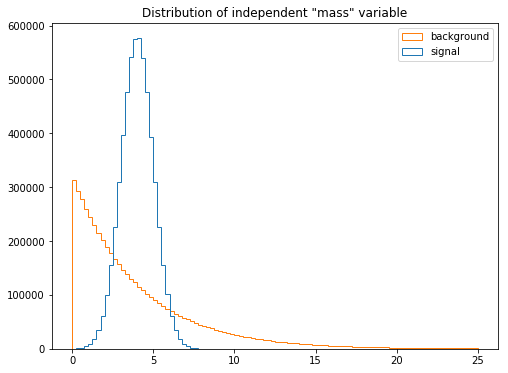

In [5]:
plt.figure(figsize=(8, 6))
_ = plt.hist(
    [mass[labels > 0.5], mass[labels < 0.5]],
    histtype='step', label=['signal', 'background'],
    bins=np.linspace(0, 25, num=101)
)
plt.title('Distribution of independent "mass" variable')
plt.legend()

In [6]:
X_train, pm_train, y_train, X_test, pm_test, y_test = utils.split(
    data, mass_probabilities, labels, split_ratios=0.8,
)

if FRACTION is not None:
    ### there is not need in additional shuffle
    X_train = X_train[::FRACTION]
    pm_train = pm_train[::FRACTION]
    y_train = y_train[::FRACTION]

In [7]:
sw_train = splot.compute_sweights(pm_train).values.astype('float32')

In [8]:
### to accelerate learning we put training data into tf.Variable
X_batch, pm_batch, sw_batch, y_batch = variable_dataset(
    session, X_train, pm_train[:, 1], sw_train[:, 1], y_train
).batch(BATCH_SIZE)

Instructions for updating:
Colocations handled automatically by placer.


## Network and loss definition

In [9]:
get_nn = lambda : net((None, 28))(
    dense(128),
    dense(64),
    dense(32),
    dense(1, activation=linear()),
    flatten(1)
)

In [10]:
loss_functions = {
    'likelihood' : lambda predictions, pm, sw, y: \
        -tf.log(pm * tf.sigmoid(predictions) + (1 - pm) * tf.sigmoid(-predictions)),

    'cross-entropy' : lambda predictions, pm, sw, y: \
        pm * tf.nn.softplus(-predictions) + (1 - pm) * tf.nn.softplus(predictions),

    'constrained-MSE' : lambda predictions, pm, sw, y: \
        (tf.sigmoid(predictions) - sw) ** 2,
    
    'MSE' : lambda predictions, pm, sw, y: \
        (predictions - sw) ** 2,
    
    's-weights' : lambda predictions, pm, sw, y: \
        sw * tf.nn.softplus(-predictions) + (1 - sw) * tf.nn.softplus(predictions),
    
    'true-labels': lambda predictions, pm, sw, y: \
        y * tf.nn.softplus(-predictions) + (1 - y) * tf.nn.softplus(predictions),
}

In [11]:
nns = dict()
for name in loss_functions:
    nns[name] = [ get_nn() for _ in range(N_NETWORKS) ]

In [12]:
predictions = dict()

for name in nns:
    predictions[name] = [
        nn(X_batch)[0] for nn in nns[name]
    ]

In [13]:
losses = dict()

for name in loss_functions:
    lf = loss_functions[name]
    losses[name] = [
        tf.reduce_mean(lf(pred, pm_batch, sw_batch, y_batch))
        for pred in predictions[name]
    ]

In [14]:
optimizers = dict()

for name in nns:
    optimizers[name] = [
        tf_updates.adam(learning_rate=1.0e-4)(loss, nn.variables())
        for loss, nn in zip(losses[name], nns[name])
    ]

Instructions for updating:
Use tf.cast instead.


## Training

In [15]:
_ = session.run([
    nn.reset() for name in nns for nn in nns[name]
])

_ = session.run([
    opt.reset() for name in optimizers for opt in optimizers[name]
])

In [16]:
### make weights of all networks the same at the start
name0 = next(iter(nns.keys()))
for i in tqdm(range(N_NETWORKS)):
    params = session.run(nns[name0][i].variables())
    
    for name in nns:
        session.run(**nns[name][i].assign(params))

In [17]:
joint_update = tf.group([
    opt.updates()
    for name in optimizers
    for opt in optimizers[name]
])

In [18]:
def draw(loss_history):
    plt.figure(figsize=(12, 6))

    for i, name in enumerate(loss_history):
        color=plt.cm.tab10(i / 10)

        for j in range(loss_history[name].shape[1]):
            ls=loss_history[name][:, j, :]
            time = np.arange(ls.shape[0])

            if j == 0:
                plt.plot(time, np.mean(ls, axis=1), label=name, color=color)
            else:
                plt.plot(time, np.mean(ls, axis=1), color=color)

    plt.ylim([0.0, 0.7])
    plt.legend(loc='upper left')
    plt.savefig('./learning_curve.png')
    plt.close()

In [19]:
observation_rate = 32
n_epoches = N_EPOCHES
n_batches = X_train.shape[0] // BATCH_SIZE // observation_rate

loss_history = dict([
    (name, np.zeros(shape=(n_epoches, N_NETWORKS, n_batches)))
    for name in losses.keys()
])

epoch_progress = tqdm(total=n_batches * observation_rate, desc='epoch', position=2, leave=True)

for i in tqdm(range(n_epoches)):
    epoch_progress.reset()

    for j in range(n_batches):
        for k in range(observation_rate):
            session.run(joint_update)

            epoch_progress.update()

        ls = session.run(losses)
        for name in ls:
            loss_history[name][i, :, j] = ls[name]

        
    draw(dict([
        (name, loss_history[name][:(i + 1)])
        for name in loss_history
    ]))

## Evaluation

In [20]:
predict = lambda data, p: np.hstack([
    session.run(p, feed_dict={ X_batch : data[indx] })
    for indx in tqdm(streams.seq(data, batch_size=1024), total=data.shape[0] // 1024)
])

In [21]:
test_predictions = dict()

for name in predictions:
    test_predictions[name] = predict(X_test, predictions[name])

In [22]:
train_predictions = dict()

for name in predictions:
    train_predictions[name] = predict(X_train, predictions[name])

In [23]:
accuracies = dict()

for name in test_predictions:
    accuracies[name] = [
        np.mean((p > 0) == (y_test > 0.5))
        for p in test_predictions[name]
    ]

In [24]:
accuracies_train = dict()

for name in test_predictions:
    accuracies_train[name] = [
        np.mean((p > 0) == (y_train > 0.5))
        for p in train_predictions[name]
    ]

In [25]:
print('Accuracy:')
for name in accuracies:
    m, s = np.mean(accuracies[name]), np.std(accuracies[name], ddof=1)
    m_train, s_train = np.mean(accuracies_train[name]), np.std(accuracies_train[name], ddof=1)
    print(name.ljust(20), '%.3lf +- %.3lf [%.3lf +- %.3lf]' % (m, s, m_train, s_train))

Accuracy:
likelihood           0.612 +- 0.001 [0.663 +- 0.003]
cross-entropy        0.603 +- 0.003 [0.668 +- 0.004]
constrained-MSE      0.611 +- 0.001 [0.665 +- 0.004]
MSE                  0.543 +- 0.001 [0.543 +- 0.003]
s-weights            0.611 +- 0.001 [0.661 +- 0.003]
true-labels          0.631 +- 0.002 [0.700 +- 0.005]


In [26]:
from sklearn.metrics import roc_auc_score

In [27]:
roc_aucs = dict()

for name in test_predictions:
    roc_aucs[name] = [
        roc_auc_score(y_test, p)
        for p in test_predictions[name]
    ]

In [28]:
roc_aucs_train = dict()

for name in test_predictions:
    roc_aucs_train[name] = [
        roc_auc_score(y_train, p)
        for p in train_predictions[name]
    ]

In [29]:
print('ROC AUC:')
for name in accuracies:
    m, s = np.mean(roc_aucs[name]), np.std(roc_aucs[name], ddof=1)
    m_train, s_train = np.mean(roc_aucs_train[name]), np.std(roc_aucs_train[name], ddof=1)
    print(name.ljust(20), '%.3lf +- %.3lf [%.3lf +- %.3lf]' % (m, s, m_train, s_train))

ROC AUC:
likelihood           0.652 +- 0.003 [0.725 +- 0.002]
cross-entropy        0.639 +- 0.004 [0.731 +- 0.003]
constrained-MSE      0.653 +- 0.003 [0.725 +- 0.002]
MSE                  0.632 +- 0.006 [0.732 +- 0.005]
s-weights            0.653 +- 0.002 [0.721 +- 0.002]
true-labels          0.680 +- 0.002 [0.771 +- 0.005]


In [30]:
def draw(predicate=lambda x: True, n_epoches=None, path=None):
    plt.figure(figsize=(12, 6))
    
    if n_epoches is None:
        key = next(iter(loss_history.keys()))
        n_epoches = loss_history[key].shape[0]

    for i, name in enumerate(loss_history):
        color=plt.cm.tab10(i / 10)
        
        if not predicate(loss_history[name]):
            continue

        for j in range(loss_history[name].shape[1]):
            ls=loss_history[name][:n_epoches, j, :]
            time = np.arange(ls.shape[0])

            if j == 0:
                plt.plot(time, np.mean(ls, axis=1), label=name, color=color)
            else:
                plt.plot(time, np.mean(ls, axis=1), color=color)
    
    plt.title('Learning curves, Higgs dataset, Deep Neural Networks')
    plt.legend(loc='upper left', fontsize=14)
    plt.xlabel('epoch', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.savefig(path, format='pdf')
    plt.show()

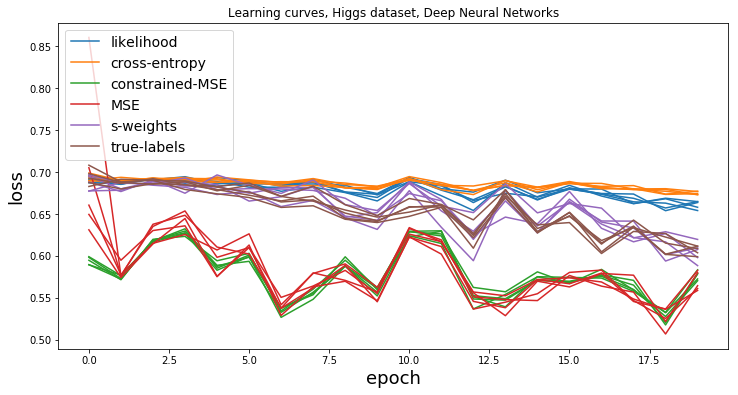

In [31]:
draw(n_epoches=20, path='./learning_curves-NN-Higgs-1.pdf')

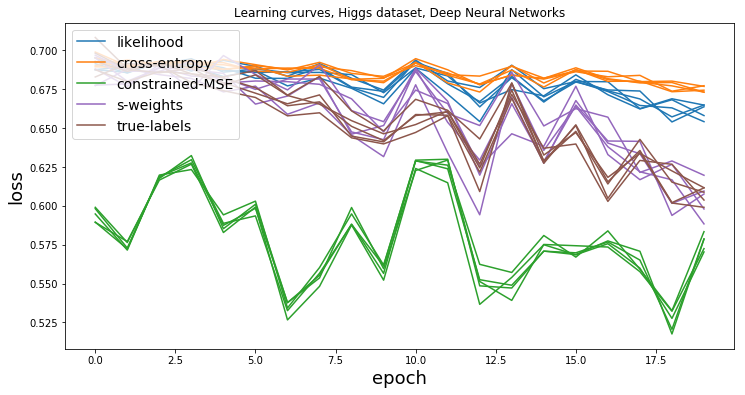

In [32]:
draw(lambda ls: np.max(np.abs(ls)) < 1, n_epoches=20, path='learning_curves-NN-Higgs-2.pdf')

In [33]:
import pickle

with open(os.path.join(DATA_ROOT, 'Higgs-NN.pickled'), 'wb') as f:
    params=session.run(
        dict([
            (name, [ nn.variables() for nn in nns[name] ])
            for name in nns
        ])
    )
    
    pickle.dump(params, f)